# 1. Importar paquetes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import itertools
from openpyxl import load_workbook

import sys
sys.path.insert(0, 'Script')
from plot_functions import plot_distribution, plot_allboxplot, plothistBancoCentralPIB, plothistBancoCentral
from reconstruccion_series import stringtofloat_BancoCentral

pd.options.display.float_format = "{:.3f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows    = None

# 2. Lectura, visualización y análisis de archivos

## 2.1 Lectura y visualización de archivo "precipitaciones.csv"

In [2]:
precipitaciones = pd.read_csv("Data\precipitaciones.csv")
precipitaciones['date'] = pd.to_datetime(precipitaciones['date'], format="%Y-%m-%d")
precipitaciones.sort_values("date", inplace=True)
display(precipitaciones.head())
display(precipitaciones.info())

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
170,1979-01-01,2.642,0.587,2.447,1.609,3.736,17.860,25.213,45.596
465,1979-02-01,1.180,2.432,3.998,4.346,16.348,17.681,18.085,34.075
305,1979-03-01,0.255,0.021,0.000,0.055,0.545,14.436,28.697,66.232
441,1979-04-01,10.174,11.746,13.722,12.989,21.881,39.136,43.618,73.548
217,1979-05-01,1.039,18.609,50.187,104.452,143.914,219.729,279.410,438.005


<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 170 to 144
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 496 non-null    datetime64[ns]
 1   Coquimbo                             496 non-null    float64       
 2   Valparaiso                           496 non-null    float64       
 3   Metropolitana_de_Santiago            496 non-null    float64       
 4   Libertador_Gral__Bernardo_O_Higgins  496 non-null    float64       
 5   Maule                                496 non-null    float64       
 6   Biobio                               496 non-null    float64       
 7   La_Araucania                         496 non-null    float64       
 8   Los_Rios                             496 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 38.8 KB


None

In [3]:
if len(precipitaciones.date.unique()) == precipitaciones.date.count():
    print("No hay fechas con registros duplicados")
else:
    n = precipitaciones.count() - len(precipitaciones.date.unique())
    print("Existen "+str(n)+" fechas duplicadas")
None if (precipitaciones.index.name == "date") else precipitaciones.set_index("date", inplace=True)

No hay fechas con registros duplicados


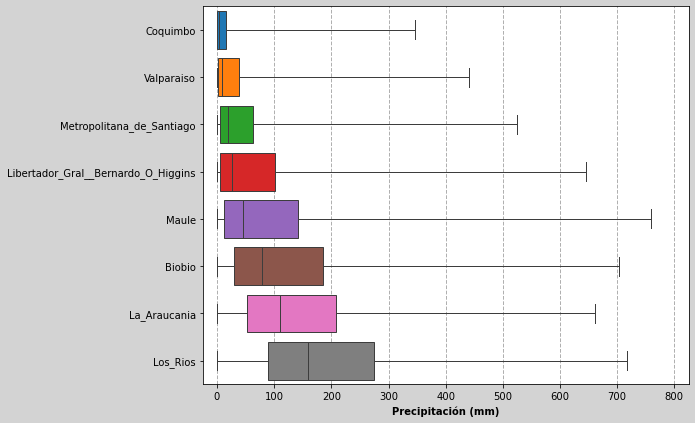

In [4]:
# figuras estaticas
for names in precipitaciones.columns:
    plot_distribution(precipitaciones, names, 0, 800, 25, "Precipitación (mm)", "Precipitaciones_distribucion_"+names)

plot_allboxplot(precipitaciones, 0, 800, 25, "Precipitación (mm)", "Precipitaciones_boxplot")

In [5]:
precipitaciones.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T.to_excel('Output/Data/resumen_descriptivo.xlsx', sheet_name="Precipitaciones")
precipitaciones.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Coquimbo,496.000,16.155,32.629,0.000,0.000,0.062,0.822,4.071,16.138,68.235,136.300,347.134
Valparaiso,496.000,32.451,55.434,0.000,0.000,0.037,1.538,9.038,38.409,127.954,248.672,441.049
Metropolitana_de_Santiago,496.000,49.667,74.361,0.000,0.009,0.213,5.298,19.088,63.408,186.645,347.755,524.593
Libertador_Gral__Bernardo_O_Higgins,496.000,72.250,101.426,0.000,0.000,0.079,5.344,25.996,101.875,275.717,460.879,645.516
Maule,496.000,98.663,122.767,0.000,0.029,0.741,11.897,45.650,142.231,353.420,534.934,759.178
Biobio,496.000,128.113,130.056,0.001,0.410,5.196,29.357,79.559,184.751,403.139,556.924,702.435
La_Araucania,496.000,151.486,126.629,0.005,2.051,16.273,52.930,110.571,208.316,404.177,553.639,661.211
Los_Rios,496.000,199.452,140.074,0.748,13.653,37.339,89.806,159.468,274.595,475.617,576.451,717.736


## 2.2 Lectura y visualización archivo "banco_central.csv"

In [6]:
bc = pd.read_csv("Data/banco_central.csv", dtype=object)
bc['Periodo'] = pd.to_datetime(bc['Periodo'], errors="coerce", format="%Y-%m-%d %H:%M:%S UTC")
bc            = bc.drop_duplicates(subset="Periodo").dropna(subset=["Periodo"]).rename({"Periodo":"date"}, axis=1).set_index("date")
bc            = bc.apply(lambda x: x.replace("a", np.nan, regex=True), axis=1)
display(bc.head(10))

,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,PIB_Agropecuario_silvicola,PIB_Pesca,PIB_Mineria,PIB_Mineria_del_cobre,PIB_Otras_actividades_mineras,PIB_Industria_Manufacturera,PIB_Alimentos,PIB_Bebidas_y_tabaco,PIB_Textil,PIB_Maderas_y_muebles,PIB_Celulosa,PIB_Refinacion_de_petroleo,PIB_Quimica,PIB_Minerales_no_metalicos_y_metalica_basica,PIB_Productos_metalicos,PIB_Electricidad,PIB_Construccion,PIB_Comercio,PIB_Restaurantes_y_hoteles,PIB_Transporte,PIB_Comunicaciones,PIB_Servicios_financieros,PIB_Servicios_empresariales,PIB_Servicios_de_vivienda,PIB_Servicios_personales,PIB_Administracion_publica,PIB_a_costo_de_factores,Impuesto_al_valor_agregado,Derechos_de_Importacion,PIB,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_diesel_centavos_de_dolargalon,Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas,Precio_del_petroleo_Brent_dolaresbarril,Precio_del_kerosene_dolaresm3,Precio_del_petroleo_WTI_dolaresbarril,Precio_del_propano_centavos_de_dolargalon_DTN,Tipo_de_cambio_del_dolar_observado_diario,Ocupados,Ocupacion_en_Agricultura_INE,Ocupacion_en_Explotacion_de_minas_y_canteras_INE,Ocupacion_en_Industrias_manufactureras_INE,Ocupacion_en_Suministro_de_electricidad_INE,Ocupacion_en_Actividades_de_servicios_administrativos_y_de_apoyo_INE,Ocupacion_en_Actividades_profesionales_INE,Ocupacion_en_Actividades_inmobiliarias_INE,Ocupacion_en_Actividades_financieras_y_de_seguros_INE,Ocupacion_en_Informacion_y_comunicaciones_INE,Ocupacion_en_Transporte_y_almacenamiento_INE,Ocupacion_en_Actividades_de_alojamiento_y_de_servicio_de_comidas_INE,Ocupacion_en_Construccion_INE,Ocupacion_en_Comercio_INE,Ocupacion_en_Suministro_de_agua_evacuacion_de_aguas_residuales_INE,Ocupacion_en_Administracion_publica_y_defensa_INE,Ocupacion_en_Enseanza_INE,Ocupacion_en_Actividades_de_atencion_de_la_salud_humana_y_de_asistencia_social_INE,Ocupacion_en_Actividades_artisticas_INE,Ocupacion_en_Otras_actividades_de_servicios_INE,Ocupacion_en_Actividades_de_los_hogares_como_empleadores_INE,Ocupacion_en_Actividades_de_organizaciones_y_organos_extraterritoriales_INE,No_sabe__No_responde_Miles_de_personas,Tipo_de_cambio_nominal_multilateral___TCM,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-03-01,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,579.846.819,570.624.122,123.491.343,110.356.254,131.350.889,130.648.285,367.818.436,162.692.807,330.305.467,643.366.109,974.948.182,103.469.519,184.460.073,807.709.837,212.409.058,301.314.934,710.242.818,115.489.064,202.838.669,546.694.889,337.915.263,5.691.837,11.393.886,793.471.519,140.103.913,512.994.015,108.482.797,896.688.023,659.936.009,118.109.613,7.638.022,1593.6,288.157,347.586.864,301.11,3.8117,109.24,76.520.246,92.91,89.171,472.484,799.068.585,798.092.771,258.428.756,901.504.814,360.108.494,18.951.548,229.653.619,547.033.124,19.153.327,155.736.824,498.854.717,341.857.582,682.423.108,151.916.628,349.444.258,445.435.266,587.837.412,362.517.856,82.567.788,201.875.908,416.124.956,190.085.519,NaN,93.621,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577
2013-04-01,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,374.895.706,606.504.665,11.702.736,10

In [7]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 611 entries, 2013-03-01 to 2008-12-01
Data columns (total 84 columns):
 #   Column                                                                              Non-Null Count  Dtype 
---  ------                                                                              --------------  ----- 
 0   Imacec_empalmado                                                                    298 non-null    object
 1   Imacec_produccion_de_bienes                                                         298 non-null    object
 2   Imacec_minero                                                                       298 non-null    object
 3   Imacec_industria                                                                    298 non-null    object
 4   Imacec_resto_de_bienes                                                              298 non-null    object
 5   Imacec_comercio                                                                     298

In [8]:
bc2 = bc.copy()
replace_dot = [True for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Imacec_empalmado,298.000,80.897,21.265,45.352,46.764,50.576,60.152,80.326,100.671,113.257,117.916,122.348
Imacec_produccion_de_bienes,298.000,87.656,13.771,57.289,62.542,66.103,76.490,87.903,98.304,109.068,116.673,123.734
Imacec_minero,298.000,93.505,10.348,58.149,63.547,70.863,88.257,95.399,100.541,107.328,113.049,113.634
Imacec_industria,298.000,86.761,13.241,58.368,62.900,66.935,74.749,87.986,97.998,105.935,109.740,112.461
Imacec_resto_de_bienes,298.000,82.002,22.060,44.075,46.581,50.865,64.070,79.996,96.547,121.990,131.810,141.504
Imacec_comercio,298.000,72.256,28.621,32.452,34.450,36.646,44.859,65.725,97.945,120.112,130.682,137.235
Imacec_servicios,298.000,78.688,25.086,35.480,39.615,42.715,54.805,78.997,101.944,115.959,121.548,123.902
Imacec_a_costo_de_factores,298.000,81.565,20.667,46.265,47.733,51.827,61.626,81.185,100.570,113.243,117.703,120.908
Imacec_no_minero,298.000,79.046,23.119,42.157,43.815,47.352,56.022,78.314,100.524,114.317,118.716,123.293


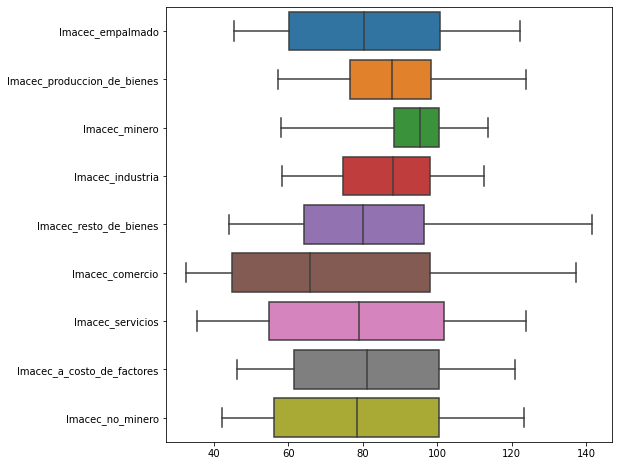

In [9]:
#Imacec
columnas_objetivo = [name_col for name_col in bc2.columns if "Imacec" in name_col] 
for n, col_name in enumerate(columnas_objetivo):
    if bc2[columnas_objetivo].dtypes.all() == object:
        Ncorrecion = [0, 0, 0, 0, 0, 4, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 20, 10)
        plothistBancoCentral(bc2, col_name, "IMACEC", "(%)")
#Resumen descriptivo

_, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=bc2[columnas_objetivo], orient="h", ax=ax, whis=[0,100])

bc2[columnas_objetivo].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
PIB_Agropecuario_silvicola,93.000,354.526,174.174,149.713,157.961,165.982,209.516,290.787,533.637,654.135,699.715,704.614
PIB_Pesca,93.000,63.230,18.202,34.258,37.996,41.952,49.808,59.338,72.988,100.939,108.674,125.723
PIB_Mineria,93.000,1272.950,80.577,1003.367,1021.902,1152.256,1230.334,1278.199,1324.928,1391.380,1433.521,1434.034
PIB_Mineria_del_cobre,93.000,1140.862,74.052,894.098,898.278,1025.498,1101.575,1152.372,1190.380,1253.351,1279.071,1287.462
PIB_Otras_actividades_mineras,93.000,132.589,14.034,97.330,105.396,112.700,123.093,131.375,140.700,156.244,163.187,164.515
PIB_Industria_Manufacturera,93.000,1287.118,64.949,1154.376,1169.981,1175.484,1238.092,1286.438,1341.781,1388.867,1408.313,1436.279
PIB_Alimentos,93.000,343.755,27.301,269.038,283.137,301.156,325.456,340.179,364.609,389.265,398.347,398.773
PIB_Bebidas_y_tabaco,93.000,165.472,14.599,137.193,138.428,142.413,155.464,164.911,173.967,192.954,201.507,204.002
PIB_Textil,93.000,29.118,4.857,13.266,13.829,19.617,26.658,29.227,32.820,34.867,37.160,38.035
PIB_Maderas_y_muebles,93.000,69.032,4.671,56.171,57.051,60.272,66.313,69.530,72.537,75.092,76.990,81.120


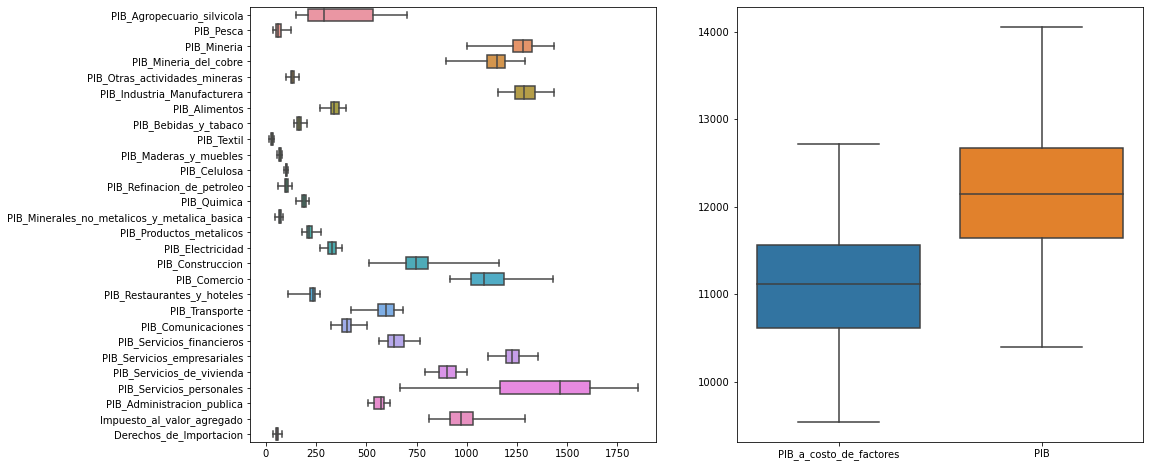

In [10]:
#PIB, IVA y derechos de importación
columnas_objetivo = [name_col for name_col in bc2.columns if "PIB" in name_col]
columnas_objetivo.append(bc2.columns[36])
columnas_objetivo.append(bc2.columns[37])

# 'PIB_Agropecuario_silvicola'
n = 0
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 0, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
# 'PIB_Pesca'
n = 1
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 0, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 20, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
# 'PIB_Mineria'
n = 2
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 3, 4, 5] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
# 'PIB_Mineria_del_cobre'
n = 3
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 250, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
# 'PIB_Otras_actividades_mineras'
n = 4
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 20, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
# 'PIB_Industria_Manufacturera'
n = 5
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 2, 0, 0, 4, 5] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Alimentos'
n = 6
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 20, 10)
#  'PIB_Bebidas_y_tabaco'
n = 7
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Textil'
n = 8
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 0, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Maderas_y_muebles'
n = 9
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Celulosa'
n = 10
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 3, 0, 4, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 50, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Refinacion_de_petroleo'
n = 11
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 15, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Quimica'
n = 12
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Minerales_no_metalicos_y_metalica_basica'
n = 13
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Productos_metalicos'
n = 14
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 0, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Electricidad'
n = 15
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Construccion'
n = 16
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 200, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Comercio'
n = 17
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 3, 0, 5, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 500, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Restaurantes_y_hoteles'
n = 18
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 4, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 500, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Transporte'
n = 19
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 3, 0, 0, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Comunicaciones'
n = 20
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Servicios_financieros'
n = 21
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Servicios_empresariales'
n = 22
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 0, 4, 5] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Servicios_de_vivienda'
n = 23
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 0, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Servicios_personales'
n = 24
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 0, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 500, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB_Administracion_publica'
n = 25
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 500, 10)
#  'PIB_a_costo_de_factores'
n = 26
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 2, 3, 0, 4, 5] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 5000, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'PIB'
n = 27
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 0, 4, 5] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 5000, 10)
    plothistBancoCentralPIB(bc2, col_name, "PIB", "(MM$)")
#  'Impuesto_al_valor_agregado'
n = 28
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 500, 10)
    plothistBancoCentralPIB(bc2, col_name, "IVA", "(MM$)")
#  'Derechos_de_Importacion'
n = 29
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentralPIB(bc2, col_name, col_name, "(MM$)")

#Resumen descriptivo

_, (ax, ay) = plt.subplots(ncols=2, figsize=(16, 8))
sns.boxplot(data=bc2[[i for i in columnas_objetivo if (i not in ["PIB_a_costo_de_factores", "PIB"])]], orient="h", ax=ax, whis=[0,100])
sns.boxplot(data=bc2[["PIB_a_costo_de_factores", "PIB"]], orient="v", ax=ay, whis=[0,100])

display(bc2[columnas_objetivo].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Precio_de_la_gasolina_en_EEUU_dolaresm3,592.000,276.264,198.367,28.400,28.664,74.307,131.300,207.884,399.252,713.481,803.123,866.391
Precio_de_la_onza_troy_de_oro_dolaresoz,611.000,576.176,466.602,34.940,35.653,63.410,291.685,384.840,816.420,1567.075,1762.115,1969.780
Precio_de_la_onza_troy_de_plata_dolaresoz,611.000,9.769,7.706,1.320,1.543,1.850,4.755,6.060,14.532,26.833,35.898,43.103
Precio_del_cobre_refinado_BML_dolareslibra,611.000,1.493,1.057,0.456,0.469,0.536,0.695,1.000,2.332,3.550,4.103,4.476
Precio_del_diesel_centavos_de_dolargalon,170.000,215.576,68.972,79.490,91.950,112.268,161.923,200.340,287.198,319.711,375.618,384.380
Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas,251.000,4.586,2.302,1.613,1.737,1.994,2.874,3.890,5.955,9.115,12.607,13.634
Precio_del_petroleo_Brent_dolaresbarril,251.000,63.653,29.816,18.600,19.890,25.075,39.790,59.370,79.870,113.570,124.435,133.900
Precio_del_kerosene_dolaresm3,251.000,456.110,208.488,132.206,137.476,180.475,272.126,439.919,579.430,801.028,893.564,996.193
Precio_del_petroleo_WTI_dolaresbarril,451.000,42.985,28.046,11.300,12.700,15.000,20.050,30.300,59.605,100.395,111.290,133.930
Precio_del_propano_centavos_de_dolargalon_DTN,155.000,88.782,36.799,29.233,33.196,40.154,55.304,88.043,112.000,152.763,174.858,187.875


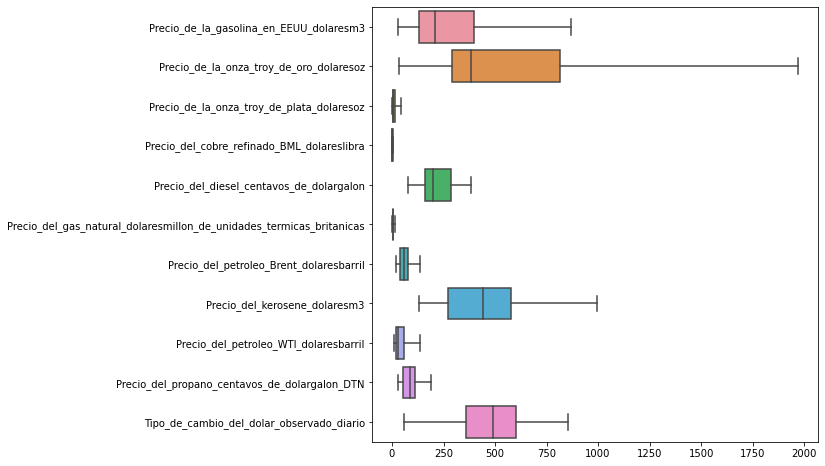

In [11]:
# Precios y Tasa de cambio
columnas_objetivo = [name_col for name_col in bc2.columns if "Precio" in name_col]

# Precio_de_la_gasolina_en_EEUU_dolaresm3
n = 0
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [1, 1, 2, 2, 2, 3, 3, 4, 5, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 28, 10, ["1979-06-01"], 10)
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/m3)")
# Precio_de_la_onza_troy_de_oro_dolaresoz
n = 1
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/oz)")
# Precio_de_la_onza_troy_de_plata_dolaresoz
n = 2
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 4, 0, 0, 0, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [7]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/oz)")
# Precio_del_cobre_refinado_BML_dolareslibra
n = 3
col_name = columnas_objetivo[n]
#display(bc2[col_name])
fechasconproblemas = ['1984-12-01', '1986-10-01', '1986-12-01', '1987-12-01', '1988-09-01', '1988-11-01','1989-02-01', '1989-10-01', 
                      '1989-12-01', '1992-09-01', '1995-07-01', '1996-07-01', '1997-01-01', '1997-03-01',
                      '1997-12-01', '1999-12-01', '2006-01-01', '2006-04-01', '2011-02-01', '2016-11-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 3, 2, 3, 3, 6, 0, 8, 8, 8] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 0.4, 10, fechasconproblemas, 10)
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/libra)")
# Precio_del_diesel_centavos_de_dolargalon
n = 4
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/galon)")
# Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas
n = 5
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 4, 0, 0, 0, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [7]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/Munidades termicas)")
# Precio_del_petroleo_Brent_dolaresbarril
n = 6
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/barril)")
# Precio_del_kerosene_dolaresm3
n = 7
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 1, 0, 2, 3, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 10**5, 10**-2)
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/m3)")
# Precio_del_petroleo_WTI_dolaresbarril
n = 8
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/barril)")
# Precio_del_propano_centavos_de_dolargalon_DTN
n = 9
col_name = columnas_objetivo[n]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentral(bc2, col_name, "Precio", "(dolares/galon)")
# "Tipo_de_cambio_del_dolar_observado_diario"
col_name = "Tipo_de_cambio_del_dolar_observado_diario"
fechasproblemas = ['1982-08-01', '1982-09-01', '1982-10-01', '1982-11-01', '1982-12-01', '1983-01-01', '1983-02-01', '1983-03-01',
                   '1983-04-01', '1983-05-01', '1983-06-01', '1983-07-01', '1983-08-01', '1983-09-01', '1983-10-01', '1983-11-01',
                   '1983-12-01', '1984-01-01', '1984-02-01', '1984-03-01', '1984-04-01', '1984-05-01', '1984-06-01', '1984-07-01', '1984-08-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 100, 10, fechasproblemas, 10**-1)
    plothistBancoCentral(bc2, col_name, "Precio", "($/dolares)")
#Resumen descriptivo
columnas_objetivo.append(col_name)

_, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=bc2[columnas_objetivo], orient="h", ax=ax, whis=[0,100])

bc2[columnas_objetivo].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Ocupados,128.000,8191.762,513.207,7073.192,7146.120,7233.804,7833.588,8213.703,8546.422,8937.394,9080.717,9118.181
Ocupacion_en_Agricultura_INE,92.000,671.861,73.370,420.865,445.370,508.625,635.903,667.880,727.799,764.549,790.247,798.093
Ocupacion_en_Explotacion_de_minas_y_canteras_INE,92.000,228.415,22.551,184.878,188.297,193.806,210.475,227.117,245.311,262.711,268.761,271.232
Ocupacion_en_Industrias_manufactureras_INE,92.000,896.757,44.108,744.755,745.573,797.329,883.125,908.988,921.123,945.145,952.379,959.785
Ocupacion_en_Suministro_de_electricidad_INE,92.000,43.935,4.903,33.192,33.216,35.286,40.759,43.801,47.303,52.014,53.473,54.327
Ocupacion_en_Actividades_de_servicios_administrativos_y_de_apoyo_INE,92.000,217.838,24.197,160.462,162.976,179.083,204.638,221.575,231.627,249.766,282.480,305.795
Ocupacion_en_Actividades_profesionales_INE,92.000,274.187,23.993,229.654,238.636,244.138,255.320,269.677,289.822,325.453,329.410,338.250
Ocupacion_en_Actividades_inmobiliarias_INE,92.000,74.805,9.872,51.794,52.303,60.861,67.632,75.368,82.877,88.445,91.089,91.891
Ocupacion_en_Actividades_financieras_y_de_seguros_INE,92.000,179.455,12.265,155.307,156.796,160.507,168.524,181.383,189.823,195.704,204.867,205.508
Ocupacion_en_Informacion_y_comunicaciones_INE,92.000,163.101,11.025,140.806,141.394,145.009,154.250,162.353,172.371,179.609,183.705,185.029


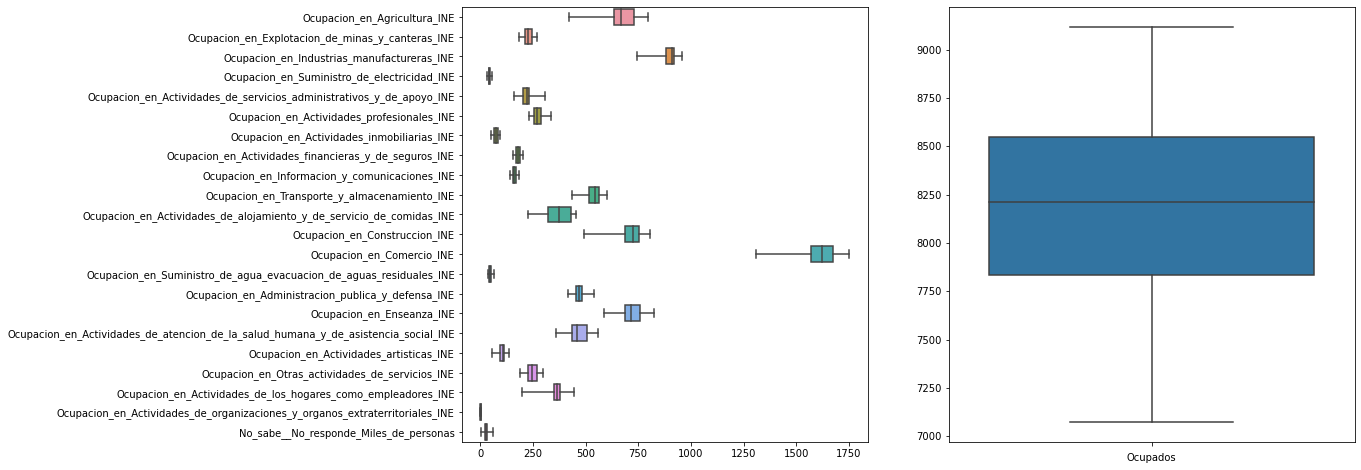

In [12]:
columnas_objetivo = [name_col for name_col in bc2.columns if "Ocupa" in name_col]
columnas_objetivo.append(bc2.columns[72])
lista_A = [columnas_objetivo[i] for i in [1, 2, 3, 12, 11, 10, 9, 8, 6, 5, 15, 16, 17, 19, 20]]
lista_B = [columnas_objetivo[i] for i in [0, 13]]
lista_C = [columnas_objetivo[i] for i in [4, 14, 7]]
lista_D = columnas_objetivo[18]
lista_E = columnas_objetivo[21]
lista_F = columnas_objetivo[22]

for col_name in lista_A:
    if bc2[col_name].dtypes == object:
        Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        replace_dot = [True if (n_bool in [9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
        bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
        plothistBancoCentral(bc2, col_name, "Ocupados", "(miles de personas)")

for col_name in lista_B:
    if bc2[col_name].dtypes == object:
        Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 3, 4, 5] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        replace_dot = [True if (n_bool in [9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
        bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
        plothistBancoCentral(bc2, col_name, "Ocupados", "(miles de personas)")

for col_name in lista_C:
    if bc2[col_name].dtypes == object:
        Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        replace_dot = [True if (n_bool in [9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
        bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
        plothistBancoCentral(bc2, col_name, "Ocupados", "(miles de personas)")

col_name = lista_D
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, 40, 10)
    plothistBancoCentral(bc2, col_name, "Ocupados", "(miles de personas)")

col_name = lista_E
fechasproblemas = ["2013-05-01", "2013-06-01", "2016-08-01", "2016-10-01", "2016-11-01", "2018-09-01", "2018-10-01", "2018-11-01", "2016-09-01",
                  "2014-04-01", "2014-05-01"]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 4, 0, 0, 0, 7, 8] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [6, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10**-1)
    plothistBancoCentral(bc2, col_name, "Ocupados", "(miles de personas)")

col_name = lista_F
fechasproblemas = ["2020-06-01", "2020-05-01"]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10**-1)
    plothistBancoCentral(bc2, col_name, "Ocupados", "(miles de personas)", False)

#Resumen descriptivo

_, (ax, ay) = plt.subplots(ncols=2, figsize=(16, 8))
sns.boxplot(data=bc2[columnas_objetivo[1:]], orient="h", ax=ax, whis=[0,100])
sns.boxplot(data=bc2[columnas_objetivo[0]], orient="v", ax=ay, whis=[0,100])
ay.set_xticklabels("")
ay.set_xlabel(columnas_objetivo[0])

bc2[columnas_objetivo].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Tipo_de_cambio_nominal_multilateral___TCM,311.000,108.081,8.273,93.411,94.499,97.511,102.460,106.044,112.603,124.927,132.509,138.331
Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,418.000,95.169,8.615,75.265,76.992,78.638,90.294,94.405,100.503,111.001,115.117,115.902


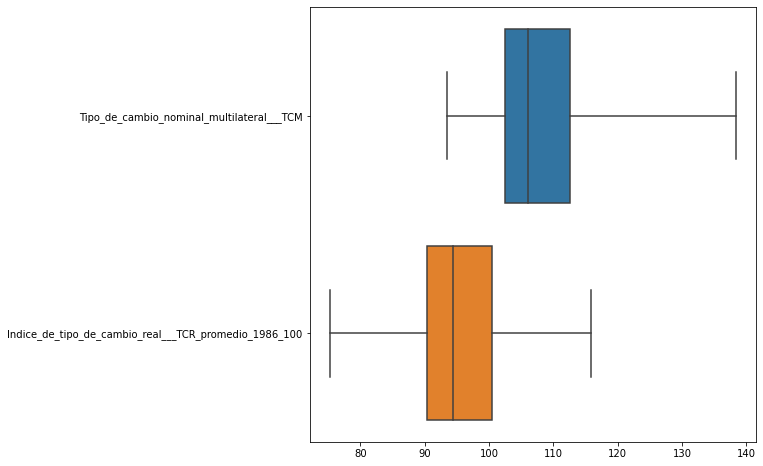

In [13]:
columnas_objetivo = [name_col for name_col in bc2.columns if ("ipo_de_cambio" in name_col) and ("dolar" not in name_col)]

# Tipo_de_cambio_nominal_multilateral___TCM
n = 0
col_name = columnas_objetivo[n]
fechasproblemas = ['1997-04-01', '1997-07-01', '1997-09-01', '2005-12-01','2006-04-01', '2008-02-01', '2008-04-01', '2010-11-01',
                   '2011-01-01', '2011-03-01', '2011-05-01', '2011-07-01','2011-08-01', '2011-09-01', '2012-02-01', '2012-03-01',
                   '2012-05-01', '2012-06-01', '2012-08-01', '2012-09-01','2012-10-01', '2012-12-01', '2013-01-01', '2013-04-01',
                   '2013-05-01', '2013-07-01', '2013-08-01', '2013-09-01','2013-10-01', '2010-12-01', '2011-06-01','1997-03-01', 
                   '2012-04-01', '2013-02-01', '2013-06-01', '1997-08-01','2008-03-01', '2010-09-01', '2010-10-01','2011-02-01',
                   '2011-04-01', '2012-07-01', '2012-11-01','2013-03-01', '1997-10-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 1, 2, 3, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [5, 6, 7, 9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10**-1)
    plothistBancoCentral(bc2, col_name, "TCM", "(-)")

# Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100
n = 1
col_name = columnas_objetivo[n]
fechasproblemas = [
    '1986-02-01', '1986-03-01', '1986-08-01', '1986-09-01', '1986-10-01', '1986-11-01', '1986-12-01', '1987-01-01', '1987-02-01',
    '1987-03-01', '1987-04-01', '1987-05-01', '1987-06-01', '1987-07-01', '1987-08-01', '1987-09-01', '1987-10-01', '1987-11-01',
    '1988-01-01', '1988-02-01', '1988-03-01', '1988-04-01', '1988-06-01', '1988-07-01', '1988-09-01', '1988-10-01', '1988-11-01',
    '1988-12-01', '1989-01-01', '1989-02-01', '1989-03-01', '1989-04-01', '1989-05-01', '1989-06-01', '1989-07-01', '1989-08-01',
    '1989-09-01', '1989-10-01', '1989-11-01', '1989-12-01', '1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01', '1990-05-01',
    '1990-07-01', '1990-08-01', '1990-09-01', '1990-10-01', '1990-11-01', '1990-12-01', '1991-01-01', '1991-02-01', '1991-03-01',
    '1991-04-01', '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01', '1991-10-01', '1991-11-01', '1991-12-01', '1992-01-01',
    '1992-08-01', '1992-09-01', '1993-04-01', '1993-05-01', '2001-08-01', '2001-09-01', '2001-10-01', '2001-11-01', '2002-09-01',
    '2002-10-01', '2002-12-01', '2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01', '2003-05-01', '2003-06-01', '2003-07-01',
    '2003-08-01', '2003-09-01', '2003-10-01', '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01', '2004-09-01', '2004-10-01',
    '2004-11-01', '2008-10-01', '2008-12-01', '2009-01-01', '2014-08-01', '2014-09-01', '2019-11-01', '2019-12-01', '2020-01-01',
    '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-09-01', '2020-10-01', '1987-12-01', 
    '1988-08-01', '1991-09-01', '2005-03-01', '2008-11-01', '2015-08-01', '2020-08-01', '1988-05-01', '1990-06-01'
    ]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10)
    plothistBancoCentral(bc2, col_name, "TCR", "(-)")

#Resumen descriptivo

_, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=bc2[columnas_objetivo], orient="h", ax=ax, whis=[0,100])

bc2[columnas_objetivo].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Indice_de_produccion_industrial,142.000,97.324,5.942,79.640,82.075,86.191,93.888,97.896,101.379,105.001,107.452,111.252
Indice_de_produccion_industrial__mineria,370.000,77.241,23.069,26.390,30.444,34.744,61.686,84.316,95.036,103.410,109.808,114.378
Indice_de_produccion_industrial_electricidad__gas_y_agua,82.000,105.117,4.424,94.137,96.773,98.555,101.905,105.331,108.679,112.261,113.343,113.484
Indice_de_produccion_industrial__manufacturera,358.000,83.289,16.830,42.264,50.101,56.659,68.932,86.832,97.647,105.976,110.764,112.555
Generacion_de_energia_electrica_CDEC_GWh,262.000,4909.355,1110.493,2724.397,2928.562,3119.995,4029.294,4817.860,5936.558,6533.852,6773.041,6798.200


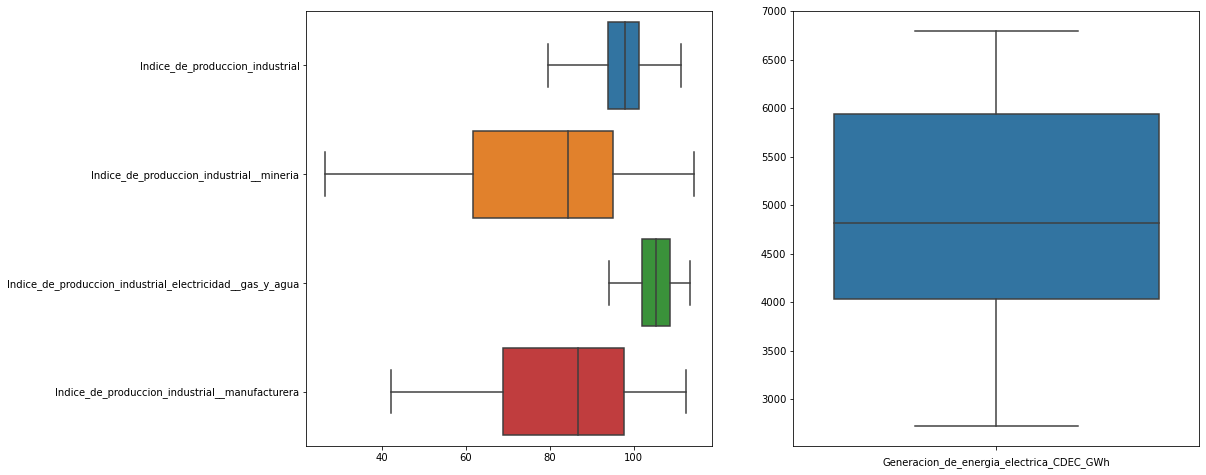

In [14]:
columnas_objetivo = [name_col for name_col in bc2.columns if ("Indice_de_produccion" in name_col)]
# Indice_de_produccion_industrial
n = 0
col_name = columnas_objetivo[n]
fechasproblemas = ['2011-12-01', '2012-03-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-03-01', '2013-07-01', '2013-08-01',
                   '2013-10-01', '2013-11-01', '2013-12-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-10-01', '2014-11-01', 
                   '2014-12-01', '2015-01-01', '2015-03-01', '2015-05-01', '2015-06-01', '2015-10-01', '2015-11-01', '2015-12-01', 
                   '2016-03-01', '2016-05-01', '2016-11-01', '2016-12-01', '2017-05-01', '2017-08-01', '2017-10-01', '2017-11-01', 
                   '2017-12-01', '2018-03-01', '2018-05-01', '2018-06-01', '2018-08-01', '2018-10-01', '2018-11-01', '2018-12-01',
                   '2019-03-01', '2019-05-01', '2019-07-01', '2019-08-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', 
                   '2020-03-01', '2020-10-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10)
plothistBancoCentral(bc2, col_name, "Índice de producción", "(%)")
# Indice_de_produccion_industrial__mineria
n = 1
col_name = columnas_objetivo[n]
fechasproblemas = ['2004-12-01', '2005-12-01', '2006-12-01', '2007-03-01', '2007-12-01', '2011-12-01', '2012-12-01', '2013-08-01',
                   '2013-10-01', '2013-11-01', '2013-12-01', '2014-05-01', '2014-06-01', '2014-10-01', '2014-11-01', '2014-12-01',
                   '2015-01-01', '2015-05-01', '2015-06-01', '2015-09-01', '2015-10-01', '2015-12-01', '2016-03-01', '2016-05-01',
                   '2016-11-01', '2016-12-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-03-01',
                   '2018-07-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-08-01', '2019-10-01', '2019-11-01',
                   '2019-12-01', '2020-05-01', '2020-08-01', '2020-10-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 4, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [7, 9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10)
plothistBancoCentral(bc2, col_name, "Índice de producción", "(%)")
# Indice_de_produccion_industrial_electricidad__gas_y_agua
n = 2
col_name = columnas_objetivo[n]
fechasproblemas = ['2014-02-01', '2014-04-01', '2014-06-01', '2014-08-01',
                   '2014-09-01', '2014-10-01', '2014-11-01', '2015-02-01',
                   '2015-09-01', '2015-11-01', '2016-09-01', '2020-09-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10**-1)
plothistBancoCentral(bc2, col_name, "Índice de producción", "(%)")
# Indice_de_produccion_industrial__manufacturera
n = 3
col_name = columnas_objetivo[n]
fechasproblemas = ['2007-03-01', '2008-03-01', '2008-04-01', '2011-03-01', '2011-11-01', '2011-12-01', '2012-03-01', '2012-04-01',
                   '2012-05-01', '2012-08-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-03-01', '2013-04-01',
                   '2013-07-01', '2013-08-01', '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01', '2014-03-01', '2014-04-01',
                   '2014-05-01', '2014-10-01', '2014-12-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-07-01', '2015-10-01',
                   '2015-11-01', '2015-12-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-08-01', '2016-11-01', '2016-12-01',
                   '2017-03-01', '2017-05-01', '2017-08-01', '2017-11-01', '2017-12-01', '2018-03-01', '2018-04-01', '2018-05-01',
                   '2018-06-01', '2018-08-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-03-01', '2019-04-01',
                   '2019-05-01', '2019-07-01', '2019-08-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
                   '2020-03-01', '2020-10-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 4, 0, 5, 6, 7] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [7, 9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10)
plothistBancoCentral(bc2, col_name, "Índice de producción", "(%)")
# "Generación eléctrica"
col_name = bc2.columns[79]
fechasproblemas = ['2015-12-01', '2016-12-01', '2019-01-01', '2019-02-01', 
                   '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
                   '2019-07-01', '2019-10-01', '2019-12-01', '2020-01-01',
                   '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
                   '2020-06-01', '2020-07-01', '2020-09-01', '2020-10-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 2, 0, 0, 3, 4, 5] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [4, 6, 9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10)
plothistBancoCentral(bc2, col_name, "Generación eléctrica", "(GWh)")
#Resumen descriptivo

_, (ax, ay) = plt.subplots(ncols=2, figsize=(16, 8))
sns.boxplot(data=bc2[columnas_objetivo], orient="h", ax=ax, whis=[0,100])
sns.boxplot(data=bc2[col_name], orient="v", ax=ay, whis=[0,100])
ay.set_xticklabels("")
ay.set_xlabel(col_name)

columnas_objetivo.append(col_name)
bc2[columnas_objetivo].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Indice_de_ventas_comercio_real_IVCM,82.000,106.991,13.022,75.735,82.038,91.267,99.907,104.088,111.006,134.750,148.049,150.150
Indice_de_ventas_comercio_real_no_durables_IVCM,82.000,103.965,11.192,76.338,81.317,92.876,99.510,102.007,105.479,133.117,141.246,142.726
Indice_de_ventas_comercio_real_durables_IVCM,82.000,119.768,24.622,73.190,78.417,87.627,99.844,115.452,136.137,164.936,176.766,181.489
Ventas_autos_nuevos,143.000,26565.412,7128.420,4658.000,6704.260,11467.000,23668.500,27801.000,31699.000,36165.699,38433.320,39263.000


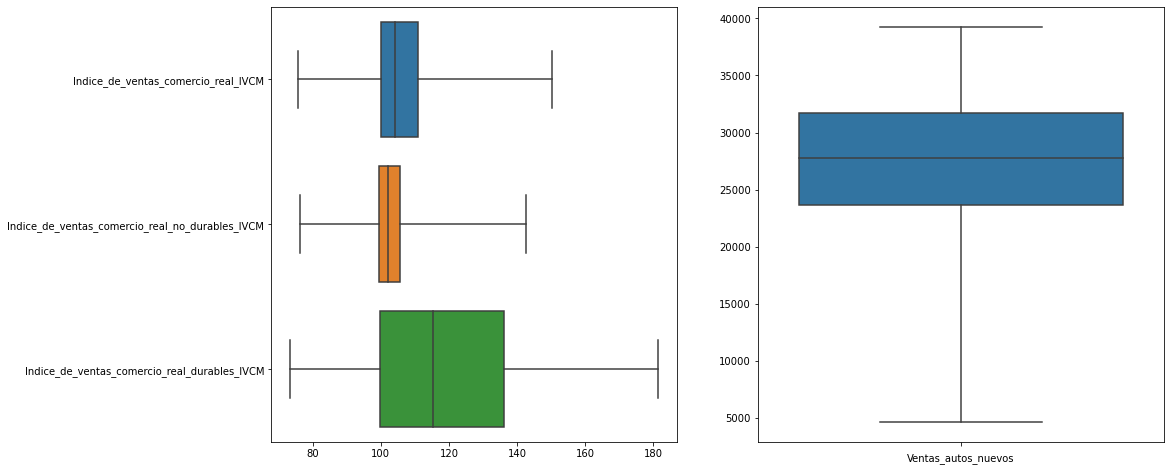

In [15]:
columnas_objetivo = [name_col for name_col in bc2.columns if ("Indice_de_ventas_comercio_real" in name_col)]
# Indice_de_ventas_comercio_real_IVCM [ 9 10 11]
n = 0
col_name = columnas_objetivo[n]
fechasproblemas = ['2014-01-01', '2014-02-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
                   '2014-10-01', '2014-11-01', '2015-01-01', '2015-02-01', '2015-04-01', '2015-06-01', '2015-07-01', '2015-09-01',
                   '2016-02-01', '2016-06-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 4, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [9, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10**-1)
    plothistBancoCentral(bc2, col_name, "Índice_de_ventas_comercio_real", "(%)")
# Indice_de_ventas_comercio_real_no_durables_IVCM [ 7 10 11]
n = 1
col_name = columnas_objetivo[n]
fechasproblemas = ['2014-01-01', '2014-02-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
                   '2014-11-01', '2015-01-01', '2015-02-01', '2015-04-01', '2015-06-01', '2015-07-01', '2015-09-01', '2016-06-01',
                   '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2015-08-01', '2016-08-01', '2017-02-01', '2019-10-01', '2019-11-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 3, 0, 0, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [7, 10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10**-1)
    plothistBancoCentral(bc2, col_name, "Índice_de_ventas", "(%)")
# Indice_de_ventas_comercio_real_durables_IVCM [10 11]
n = 2
col_name = columnas_objetivo[n]
fechasproblemas = ['2014-01-01', '2014-02-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-09-01', '2014-10-01',
                   '2014-11-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
                   '2015-10-01', '2016-01-01', '2016-02-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01']
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 5, 6] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [True if (n_bool in [10, 11]) else False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "", fechasproblemas, 10**-1)
    plothistBancoCentral(bc2, col_name, "Índice_de_ventas", "(%)")
# Ventas_autos_nuevos [4 5]
n = 3
col_name = bc2.columns[-1]
if bc2[col_name].dtypes == object:
    Ncorrecion  = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    replace_dot = [False for n_bool in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    bc2 = stringtofloat_BancoCentral(bc2, col_name, Ncorrecion, replace_dot, "", "")
    plothistBancoCentral(bc2, col_name, "Ventas de autos nuevos", "(unidades)")

_, (ax, ay) = plt.subplots(ncols=2, figsize=(16, 8))
sns.boxplot(data=bc2[columnas_objetivo], orient="h", ax=ax, whis=[0,100])
sns.boxplot(data=bc2[col_name], orient="v", ax=ay, whis=[0,100])
ay.set_xticklabels("")
ay.set_xlabel(col_name)

#Resumen descriptivo
columnas_objetivo.append(col_name)
bc2[columnas_objetivo].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

In [16]:
bc = bc2
bc.to_csv("Output/Data/banco_central_preprocesado.csv")
bc.dtypes.unique()

array([dtype('float32')], dtype=object)

In [17]:
ExcelWorkbook = load_workbook('Output/Data/resumen_descriptivo.xlsx')
writer = pd.ExcelWriter('Output/Data/resumen_descriptivo.xlsx', engine = 'openpyxl')
writer.book = ExcelWorkbook
bc.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T.to_excel(writer, sheet_name="Banco Central")
writer.save()
writer.close()

## 2.3 Análisis y comentarios de ambos archivos: 

<!-- print(
    f"De acuerdo a lo observado anteriormente:\n"
    f"1. No hay registros de precipitación duplicados y ni datos anómalos, teniendo 496 observaciones para cada región.\n"
    f"2. Respecto al resumen descriptivo, se presentan los siguientes resultados para los valores medios:")
for col_name in precipitaciones.columns:
    mean = precipitaciones[col_name].mean()
    std = precipitaciones[col_name].std()
    print(
    f""+col_name+": {:.2f} +/- {:.2f} (mm)".format(mean, std)
    ) -->